In [170]:
import numpy as np
import random
import math
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [171]:
def move(x: float, y: float, angle: float, distance: float) -> tuple:
    return (
        x + math.cos(math.radians(angle)) * distance,
        y + math.sin(math.radians(angle)) * distance
    )


def is_out_of_bounds(x: float, y: float, width: int, height: int):
    return (x < 0) | (x >= width) | (y < 0) | (y >= height)


def decay(grid: np.ndarray, amount: float) -> np.ndarray:
    grid = grid - amount
    grid[grid < 0] = 0
    return grid


def blur(grid: np.ndarray, kernel: tuple[int] = (3,3)) -> np.ndarray:
    return cv2.blur(grid, kernel)


class Agent:
    def __init__(self, x, y, direction=None):
        self.x = x
        self.y = y
        self.direction = direction if direction is not None else random.random() * 360 
        
        self.sensor_angle = 25
        self.sensor_distance = 9
        self.fl = 0
        self.f = 0
        self.fr = 0
    
    def move(self):
        x, y = move(self.x, self.y, self.direction, 1)
        if is_out_of_bounds(x, y, width, height):
            self.perturb_randomly(180)
            self.move()
        else:
            self.x = x
            self.y = y
    
    def perturb_randomly(self, degrees: float):
        self.direction = (self.direction + random.randrange(-degrees, degrees)) % 360
        
    def perturb(self):
        if (self.f > self.fl) and (self.f > self.fr):
            return
        elif (self.f < self.fl) and (self.f < self.fr):
            if random.random() < 0.5:
                self.direction = (self.direction - self.sensor_angle) % 360
            else:
                self.direction = (self.direction + self.sensor_angle) % 360
        elif self.fl < self.fr:
            self.direction = (self.direction + self.sensor_angle) % 360
        elif self.fr < self.fl:
            self.direction = (self.direction - self.sensor_angle) % 360
        else:
            return
        
    def read_sensors(self, grid: np.ndarray):
        self.fl = self._get_sensor_reading((self.direction - self.sensor_angle) % 360, grid)
        self.f = self._get_sensor_reading(self.direction, grid)
        self.fr = self._get_sensor_reading((self.direction + self.sensor_angle) % 360, grid)

    def _get_sensor_reading(self, angle: float, grid: np.ndarray) -> float:
        x, y = move(self.x, self.y, angle, self.sensor_distance)
        if is_out_of_bounds(x, y, width, height):
            return 0
        return grid[math.floor(y), math.floor(x)]
    
    def deposit(self, grid: np.ndarray, amount: float = 5):
        grid[math.floor(self.y), math.floor(self.x)] += amount

# Simulation

In [231]:
size = 480
width = size
height = size
grid = np.zeros((size, size))

x_data = []
y_data = []

agents: list[Agent] = []
n_agents = round(size * size * 0.15)

for _ in range(n_agents):
    agent = Agent(random.randrange(0, size),  random.randrange(0, size))
    agents.append(agent)

for i in tqdm(range(1000)):
    for agent in agents:
        agent.read_sensors(grid)
        agent.perturb()
        agent.move()
        agent.deposit(grid)
    x_data.append([agent.x for agent in agents])
    y_data.append([agent.y for agent in agents])
    # decay
    grid *= 0.9
    grid = blur(grid, kernel=(1,1))

100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


# Vizualization

## Agents

In [206]:
import matplotlib

In [233]:
len(x_data)

1000

In [245]:
grid = np.zeros((1000, 3, size, size))

for i, (xs, ys) in enumerate(zip(x_data, y_data)):
    for x, y in zip(xs, ys):
        grid[i, 0, math.floor(x), math.floor(y)] += 0.2
        grid[i, 1, math.floor(x), math.floor(y)] += 0.2
        grid[i, 2, math.floor(x), math.floor(y)] += 0.2
    grid[i] = grid[i] / grid[i].max() * 255
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.set_xlim(0, size)
#     ax.set_ylim(0, size)
#     ax.set_facecolor("black")
#     plt.scatter(xs, ys, color="white", s=1, alpha=0.2)
#     plt.savefig(f"{i}".zfill(3) + ".png", dpi=300)
img_grid = grid.astype("uint8")

In [220]:
import array2gif

In [246]:
array2gif.write_gif(img_grid, "test.gif", fps=24)

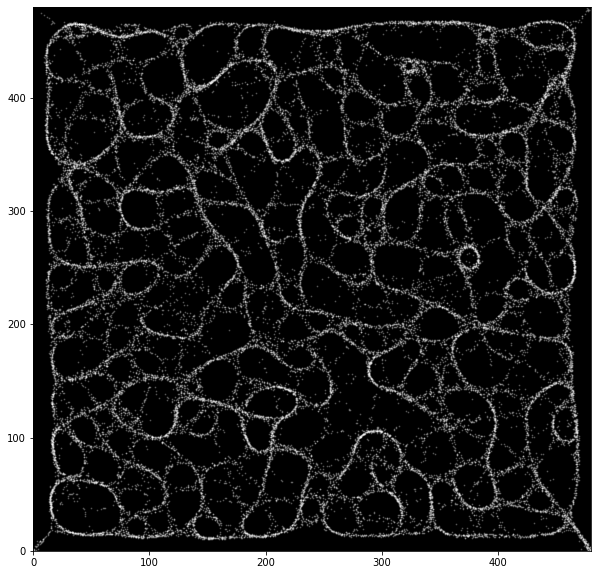

In [197]:
xs = [agent.x for agent in agents]
ys = [agent.y for agent in agents]

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(0, size)
ax.set_ylim(0, size)
ax.set_facecolor("black")
plt.scatter(xs, ys, color="white", s=1, alpha=0.2)

## Pheromone Grid

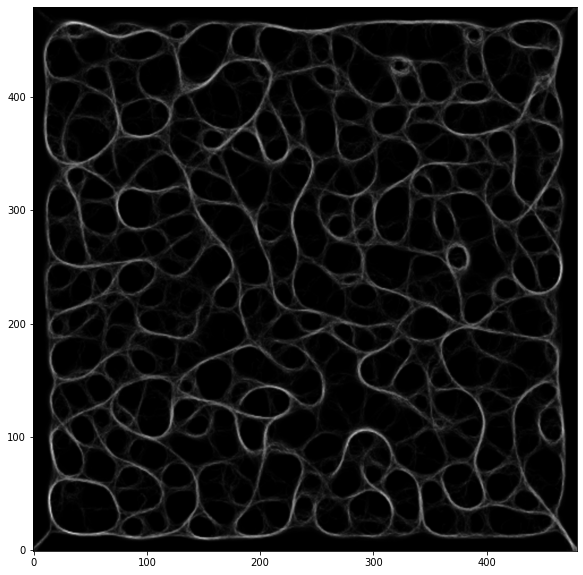

In [198]:
plt.figure(figsize=(10,10))
im = plt.imshow(grid, origin="lower", cmap="Greys_r", interpolation="bicubic")